# Ngram Wordcloud for Tweets

This notebook walks you through creating a wordcloud of frequent ngrams in tweets, specifically bigrams and trigrams.

### Before we begin

Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-R.ipynb](textPrep-R.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.

### Let's get started

First, we need to set our working directory (setwd). This is the folder that points to where your data is stored. In our case we have multiple folders that we may want to use at some point, but they are all contained in our Text-Analysis folder, so we will set that as our working directory.

In [1]:
#Set the working directory
setwd("~/Text-Analysis/")

#### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."


These packages are used within the steamgraph script:

- **tm:** this package provides tools (functions) for performing various types of text mining. In this notebook, we will use tm to perform text cleaning in order to have uniform data for analysis. Check out [this link](https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf) for the documentation!

- **wordcloud:** Plots wordclouds.

- **ngram:** This is a collection of utilities for creating, displaying, summarizing, and "babbling" n-grams.

- **stringr:** A consistent, simple and easy to use set of wrappers around the fantastic 'stringi' package.

In [2]:
library(tm)
library(wordcloud)
library(ngram)
library(stringr)
library(readtext)

Loading required package: NLP
Loading required package: RColorBrewer


Read in the .csv or JSON file containing the tweet content.

In [3]:
tweets <- readtext('data/twitter/parkland/neverAgain.csv', text_field = "text")

### Prepare text data

First we are going to take the list of 50k+ tweets created when we grabbed the file above and convert it to utf-8 encoding, grabbing only the text column. We use 'iconv' to convert the column labeled 'text' found in our 'tweets' variable above (tweets$text) and then tell it we want to convert the text to = utf-8.

In [4]:
#corpus <- iconv(tweets, to = "utf-8")

Next, we need to eliminate any characters that are not UTF-8. We will create a function that does this and then call the function in the next line. If you know the encoding (in this case it usually is ASCII), then put it in the first set of quotes. If you do not, then just put another "UTF-8" so (x, "ASCII", "UTF-8", sub="") or (x, "UTF-8", "UTF-8", sub=""). Then we simply apply our function we named removeChars to our corpus variable.

In [5]:
removeChars <- function(x) iconv(x, "ASCII", "UTF-8", sub="")
corpus <- removeChars(tweets)

### Clean Tweets
To clean the corpus in this example, we are using the tm package's built in tools to:
1. Convert all the text to lower case, so that "Never" and "never" are not seen as seperate words.
2. Eliminate numbers, especially if they skew your results any, however, numbers may also be important, so that is why this one is optional.
3. Remove all punctuation so that only alphanumeric characters are read.
4. Remove url's so we don't end up with a lot of 'http', 'https', et cetera. We do this by:
    - creating a function that uses regular expressions to remove them
    - then apply that function to our "corpus." 
5. Remove stopwords. In our plain text wordcloud, we used tm's options for a wordlist and will be doing the same again. Concatenated onto the list are common twitter words not yet eliminated such as "rt" (retweet), "amp" (&), the subject of our tweets "neveragain", and a couple twitter handles with the "@" removed.
6. Remove extra white space so what was "well said @emma4change" does not end up as "well said &nbsp;&nbsp;emma4change" but becomes "well said emma4change" (without the extra space).

In [6]:
corpus <- tolower(corpus)
corpus <- removeNumbers(corpus)
corpus <- gsub("[[:punct:]]", "", corpus)
removeURL <- function(x) gsub("http[[:alnum:]]*", "", x)
corpus <- removeURL(corpus)
corpus <- removeWords(corpus, c(stopwords("SMART"), 'amp','rt', 'emmachange', 'xokarminox', 'neveragain', ','))
corpus <- stripWhitespace(corpus)

### Get bigrams

Next we collect the most frequent ngrams found in our tweets, in this case bigrams. For trigrams see below. 
 
1. We change our Corpus object to a string.
2. We preprocess our corpus and remove any punctuation that may have been added when converting back to a string
3. We use the ngram_asweka function from the ngram package to pull bigrams from our tweets.
4. We then put those bigrams into a data frame.
5. Finally, we sort them in descending order by frequency.

In [7]:
corpus <- toString(corpus)
corpus <- preprocess(corpus, remove.punct = TRUE)
ntoken <- ngram_asweka(corpus, min = 2, max = 2, sep = " ")
ngrm_word <- data.frame(table(ntoken))
sort_ngrm <- ngrm_word[order(ngrm_word$Freq,decreasing=TRUE),]

head(sort_ngrm, 10)

,ntoken,Freq
71966,midterm elections,3093
4659,anger feel,3086
31597,elections anger,3085
35894,feel indescribable,3085
38852,forgetting midterm,3085
59300,kidding forgetting,3085
26819,difference difference,2213
44205,gun control,1093
54680,indescribable kidding,1023
90433,protect kids,952


### Remove ngram stopwords

Only use this if you find ngrams in the wordcloud that you need to remove. Just add words in quotes and separated by a comma to the stop_words list below. Run this box of code and then rerun the wordcloud.

In [8]:
stop_words <- c('difference difference', 'movement movement')
sort_ngrm$ntoken <- gsub(paste0(stop_words, collapse = "|"), "", sort_ngrm$ntoken)

### Plot the bigram wordcloud

Plot the wordcloud! There are a number of arguments you can customize: "scale"" indicates the size of the words; "max.words" controls how many words show up in the wordcloud, and min.freq says how many occurances of the ngram there needs to be in order for it to be plotted in the wordcloud. We've used the "RColorBrewer" which is built in to the wordcloud package to give us access to some predefined palettes. Note that if you change the palette, you need to tell the argument how many colors are in the new palette. 

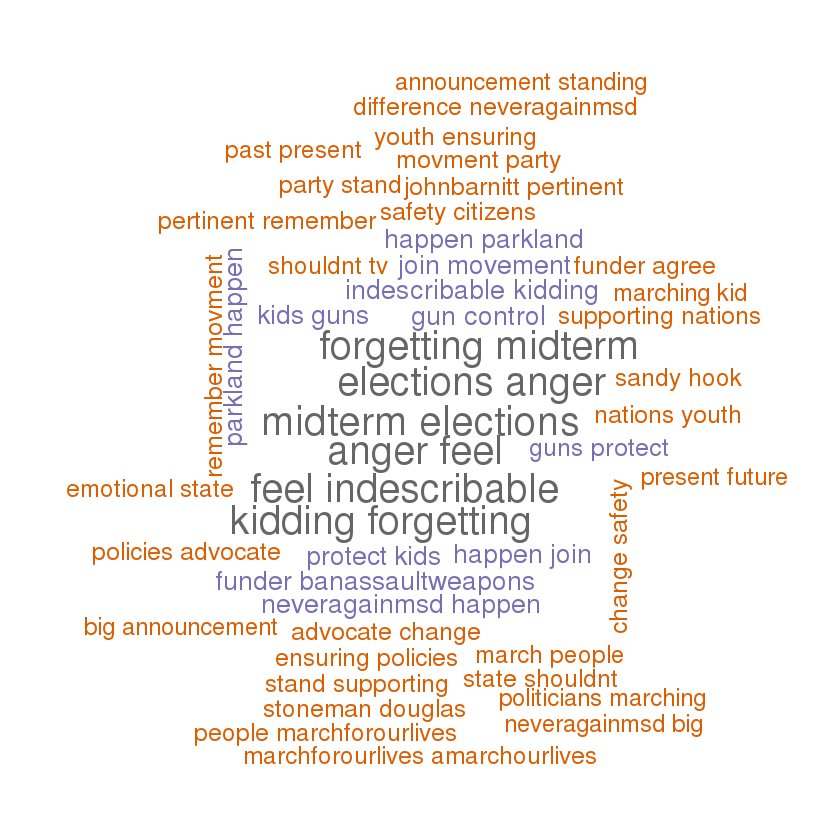

In [9]:
wordcloud(sort_ngrm$ntoken,sort_ngrm$Freq,random.order=FALSE,scale = c(2,1),min.freq = 2,colors = brewer.pal(8,"Dark2"),max.words=50)


## VOILA!!